대기시간: 접안(배를 육지에 대는 것)전에 선박이 해상에 정박(해상에 닻을 바다 밑바닥에 내려놓고 운항을 멈추는 것)하는 시간

산출된 항차(선박의 여정)데이터를 활용하여 항만 內 선박의 대기 시간을 예측

# 1. 라이브러리 호출

In [3]:
!pip install catboost
!pip install optuna
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import lightgbm as lgb
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, KFold

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive/')
import os
if os.getcwd() != '/content/drive/My Drive':
    os.chdir('./drive/My Drive')

Mounted at /content/drive/


In [6]:
!pwd

/content/drive/My Drive


# 2. train, test data load

In [7]:
train = pd.read_csv('./HD/Data/train.csv')
test = pd.read_csv('./HD/Data/test.csv')

In [8]:
print(len(train), len(test))

391939 220491


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220491 entries, 0 to 220490
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           220491 non-null  object 
 1   ARI_CO              220491 non-null  object 
 2   ARI_PO              220491 non-null  object 
 3   SHIP_TYPE_CATEGORY  220491 non-null  object 
 4   DIST                220491 non-null  float64
 5   ATA                 220491 non-null  object 
 6   ID                  220491 non-null  object 
 7   BREADTH             220491 non-null  float64
 8   BUILT               220491 non-null  int64  
 9   DEADWEIGHT          220491 non-null  int64  
 10  DEPTH               220491 non-null  float64
 11  DRAUGHT             220491 non-null  float64
 12  GT                  220491 non-null  int64  
 13  LENGTH              220491 non-null  float64
 14  SHIPMANAGER         220491 non-null  object 
 15  FLAG                220491 non-nul

ARI_CO: 도착항의 소속국가(도착항 앞 2글자)
- 'CN', 'JP', 'RU', 'AU', 'SG', 'ZA', 'KR', 'TW', 'TT', 'ID', 'BR', 'QA', 'LV', 'MZ', 'US', 'IN', 'UA', 'CA', 'MY', 'PE', 'VN', 'FI', 'CL', 'VE', 'PH'

ARI_PO: 도착항의 항구명(도착항 뒤 글자)
- 'EKP8', 'EUC8', 'NGG6', 'TMR7', 'NNC2', 'ZAG4', 'MIA8', 'QYY1', 'WHH4', 'YDP4', 'KSF1', 'VYJ1', 'GIW5', 'SPG1', 'CXL1', 'BGD2', 'FCD5', 'QQW1', 'JWI3', 'HGH2', 'IVU2', 'URE2', 'WEY7', 'LXJ7', 'IEW6', 'UVK6', 'MMW5', 'JEN5', 'YRT6', 'VXM8', 'HYG5', 'NCU8', 'JTD1', 'VFD8', 'AZU6', 'AIB7', 'KIU2', 'TDA5', 'WXQ2', 'MCG4', 'QEA4', 'OZD2', 'PDL4', 'UIR7', 'QGN3', 'UJM2', 'TMW2', 'WAF5', 'NQO4', 'CEI5', 'DMD4', 'EVL6', 'XVZ3', 'JER7', 'QTU5', 'XIU1', 'EVX2', 'BAZ5', 'QGL7', 'PPM2', 'RKA2', 'PEL6', 'LHD1', 'URD4', 'TXO3', 'BGX4', 'FFM2', 'YFK5', 'SLZ5', 'QRN3', 'EIA2', 'FAV3', 'OKM4', 'OBZ3', 'CSP6', 'PAF4', 'TBL3', 'JGL5', 'TYY2', 'XGX5', 'UEW5', 'GRQ5', 'HYV6', 'REJ1', 'PUF3', 'SXD2', 'FTQ1', 'PBQ1', 'JDG8', 'MOC5', 'DEJ2', 'XEO4', 'GQJ7', 'EFG4', 'OOV8', 'UPI6', 'JEA6', 'QXE2', 'DIN2', 'ZME5', 'ONW1', 'XZF6', 'RGT8'
       
SHIP_TYPE_CATEGORY: 선종 통합 바탕으로 5대 선종으로 분류
- 'Bulk', 'Container', 'Cargo', 'Tanker'

DIST: 정박지(ber_port)와 접안지 사이의 거리

ATA: anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival)

ID: 선박식별 일련번호

BREADTH: 선박의 폭

BUILT: 선박의 연령

DEADWEIGHT: 선박의 재화중량톤수

DEPTH: 선박의 깊이

DRAUGHT: 흘수 높이

GT: 용적톤수(Gross Tonnage)값

LENGTH: 선박의 길이

SHIPMANAGER: 선박 소유주

FLAG: 선박의 국적

U_WIND: 풍향 u벡터

V_WIND: 풍향 v벡터

AIR_TEMPERATURE: 기온

BN: 보퍼트 풍력 계급

ATA_LT: anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H)

DUBAI: 해당일의 두바이유 값

BRENT: 해당일의 브렌트유 값

WTI: 해당일의 WTI 값

BDI_ADJ: 조정된 벌크운임지수

PORT_SIZE: 접안지 폴리곤 영역의 크기

#### <span style="color:blue"> target </span>
CI_HOUR: 대기시간

In [10]:
train.head()

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


In [11]:
# target column 없음
test.head()

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE
0,TEST_000000,SG,GIW5,Container,1.826589,2020-06-18 11:58,K322654,50.0,18,117000,...,109000,340.0,KQMD74,Panama,0.37,1.63,27.1,1.587063,19,0.002615
1,TEST_000001,CN,WEY7,Cargo,25.399386,2021-05-26 22:20,E376681,10.0,13,3810,...,2560,80.0,LBYS27,Belize,-2.79,-2.33,14.2,2.663972,6,0.001028
2,TEST_000002,CN,NGG6,Container,111.079467,2019-12-16 0:09,F811111,20.0,26,10900,...,8440,140.0,EKFV15,Singapore,0.04,-4.91,9.3,3.255315,8,0.001743
3,TEST_000003,CA,FFM2,Bulk,9.175258,2015-11-16 5:30,A737561,30.0,9,55800,...,31500,190.0,MASW32,Panama,NaN,NaN,NaN,NaN,2,0.000182
4,TEST_000004,JP,QYY1,Container,0.000000,2018-10-24 1:11,A827175,30.0,19,39800,...,33000,220.0,SIEL54,Liberia,NaN,NaN,NaN,NaN,10,0.000552


In [12]:
# DIST가 0이면 CI_HOUR도 0이어야함 - 개념적으로
DIST_0 = train[train['DIST'] == 0]
CI_HOUR_NOT_0_idx = DIST_0.index[DIST_0['CI_HOUR'] != 0].tolist()
train.loc[CI_HOUR_NOT_0_idx, ['CI_HOUR']] = 0
#train

train.drop(columns=['SAMPLE_ID', 'ID'], inplace=True)
test.drop(columns=['SAMPLE_ID', 'ID'], inplace=True)

#도착 국가와 항구 합치기
train['ARI_COPO'] = train['ARI_CO'] + '_' + train['ARI_PO']
test['ARI_COPO'] = test['ARI_CO'] + '_' + test['ARI_PO']

# ARI_CO, ARI_PO 컬럼 제거
train.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)
test.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)

In [13]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday # 요일(0-월, 1-화)

# datetime 컬럼 제거
train.drop(columns=['BUILT', 'ATA_LT','ATA'], inplace=True)
test.drop(columns=['BUILT', 'ATA_LT','ATA'], inplace=True)

In [14]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import bisect

categorical_features = ['ARI_COPO', 'SHIP_TYPE_CATEGORY',  'SHIPMANAGER', 'FLAG']
encoders = {}


for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    encoders[feature] = le

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    test[feature] = le.fit_transform(test[feature].astype(str))
    encoders[feature] = le

train.head()

Encoding features: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


,SHIP_TYPE_CATEGORY,DIST,BREADTH,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,...,BN,PORT_SIZE,CI_HOUR,ARI_COPO,year,month,day,hour,minute,weekday
0,2,30.881018,30.0,24300,10.0,10.0,16700,180.0,686,89,...,NaN,0.002615,3.450000,90,2018,12,17,21,29,0
1,0,0.000000,30.0,35900,10.0,10.0,23500,180.0,4720,74,...,NaN,0.000217,0.000000,52,2014,9,23,6,59,1
2,2,0.000000,50.0,146000,30.0,20.0,140000,370.0,1370,73,...,NaN,0.001614,0.000000,23,2015,2,3,22,0,1
3,2,0.000000,20.0,6910,10.0,10.0,5400,120.0,3809,5,...,2.629350,0.000356,0.000000,66,2020,1,17,4,2,4
4,2,27.037650,50.0,116000,20.0,10.0,96600,300.0,1687,67,...,2.495953,0.002615,253.554444,90,2020,1,26,7,51,6


In [15]:
# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [16]:
# hour에 대한  cos 변환
train['hour_cos'] = np.cos(2 * np.pi * train['hour'] / 24)
# month에 대한  cos 변환
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
# day에 대한  cos 변환 (day는 월의 일 수에 따라 다르므로 가장 흔한 30일로 나눕니다.)
train['day_cos'] = np.cos(2 * np.pi * train['day'] / 30)
# weekday에 대한  cos 변환
train['weekday_cos'] = np.cos(2 * np.pi * train['weekday'] / 7)
# minute에 대한  cos 변환
train['minute_cos'] = np.cos(2 * np.pi * train['minute'] / 60)
# 연도 데이터에 코사인 변환 적용
train['year_cos'] = np.cos(2 * np.pi * train['year'] / max(train['year']))  # 연도의 최대값으로 나누어 정규화

# hour에 대한  cos 변환
test['hour_cos'] = np.cos(2 * np.pi * test['hour'] / 24)
# month에 대한  cos 변환
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)
# day에 대한  cos 변환 (day는 월의 일 수에 따라 다르므로 가장 흔한 30일로 나눕니다.)
test['day_cos'] = np.cos(2 * np.pi * test['day'] / 30)
# weekday에 대한  cos 변환
test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7)
# minute에 대한  cos 변환
test['minute_cos'] = np.cos(2 * np.pi * test['minute'] / 60)
# 연도 데이터에 코사인 변환 적용
test['year_cos'] = np.cos(2 * np.pi * test['year'] / max(test['year']))  # 연도의 최대값으로 나누어 정규화


hours_col = ['hour','day','month','minute','weekday','year']
train = train.drop(hours_col, axis=1)
test = test.drop(hours_col, axis=1)

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, QuantileTransformer

def quantileTransform(data) :
    qt = QuantileTransformer()
    scaled_data = pd.DataFrame(qt.fit_transform(data), columns=data.columns)
    return scaled_data

def logTransform(data) :
    scaled_cols = data.columns
    scaled_data = data.apply(lambda x: np.log1p(x))
    return scaled_data

left_skewed_cols = ['DEADWEIGHT', 'GT', 'DIST', 'BN']
right_skewed_cols = ['AIR_TEMPERATURE']

# train_scaler
train[left_skewed_cols] = logTransform(train[left_skewed_cols])
train[right_skewed_cols] = quantileTransform(train[right_skewed_cols])
# test_scaler
test[left_skewed_cols] = logTransform(test[left_skewed_cols])
test[right_skewed_cols] = quantileTransform(test[right_skewed_cols])



# 그 외 수치
#minmax? standard?
from sklearn.preprocessing import RobustScaler

s_columns = ['BREADTH', 'DEPTH', 'DRAUGHT',  'LENGTH', 'U_WIND', 'V_WIND', 'PORT_SIZE']
standardScaler = MinMaxScaler()

train[s_columns] = standardScaler.fit_transform(train[s_columns])
test[s_columns] = standardScaler.transform(test[s_columns])
train

,SHIP_TYPE_CATEGORY,DIST,BREADTH,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,...,BN,PORT_SIZE,CI_HOUR,ARI_COPO,hour_cos,month_cos,day_cos,weekday_cos,minute_cos,year_cos
0,2,3.462011,0.4,10.098273,0.333333,0.5,9.723224,0.421053,686,89,...,1.310221,1.000000,3.450000,90,7.071068e-01,1.000000e+00,-0.913545,1.000000,-9.945219e-01,0.999879
1,0,0.000000,0.4,10.488520,0.333333,0.5,10.064798,0.421053,4720,74,...,1.310221,0.081242,0.000000,52,6.123234e-17,-1.836970e-16,0.104528,0.623490,9.945219e-01,0.999609
2,2,0.000000,0.8,11.891369,1.000000,1.0,11.849405,0.921053,1370,73,...,1.310221,0.616515,0.000000,23,8.660254e-01,5.000000e-01,0.809017,0.623490,1.000000e+00,0.999691
3,2,0.000000,0.2,8.840870,0.333333,0.5,8.594339,0.263158,3809,5,...,1.289053,0.134672,0.000000,66,5.000000e-01,8.660254e-01,-0.913545,-0.900969,9.781476e-01,0.999957
4,2,3.333548,0.8,11.661354,0.666667,0.5,11.478344,0.736842,1687,67,...,1.251606,1.000000,253.554444,90,-2.588190e-01,8.660254e-01,0.669131,0.623490,5.877853e-01,0.999957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,2,0.000000,0.2,8.827761,0.333333,0.5,8.480737,0.236842,2562,20,...,1.310221,0.209594,0.000000,61,2.588190e-01,-1.000000e+00,0.309017,0.623490,9.781476e-01,0.999826
391935,0,1.929287,0.0,8.058644,0.333333,0.5,7.378384,0.157895,2400,124,...,0.812481,1.000000,144.061389,90,1.000000e+00,5.000000e-01,-0.978148,-0.222521,-8.090170e-01,0.999923
391936,0,4.271936,0.4,11.007104,0.666667,0.5,10.457401,0.473684,6106,102,...,1.752023,0.057661,41.482222,97,8.660254e-01,6.123234e-17,0.104528,0.623490,-8.660254e-01,0.999981
391937,2,2.346428,0.4,10.077483,0.333333,0.5,9.735128,0.394737,1771,22,...,1.310221,0.377319,7.485278,93,-2.588190e-01,8.660254e-01,-0.104528,-0.900969,2.832769e-16,0.999691


# 4. 모델 학습 및 특성 중요도 확인

In [62]:
train = pd.read_csv('./HD/Data/scaled_train.csv')
test = pd.read_csv('./HD/Data/scaled_test.csv')

In [63]:
# 함수 정의
def train_and_evaluate(model, model_name, X_train, y_train):
    model.fit(X_train, y_train)

    # 변수 중요도
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort() # index

    plt.figure(figsize=(10, len(X_train.columns)/2))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']
X_test = test

## 4. 2 변수 중요도로 나눠서 학습

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2514
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 21
[LightGBM] [Info] Start training from score 22.394528


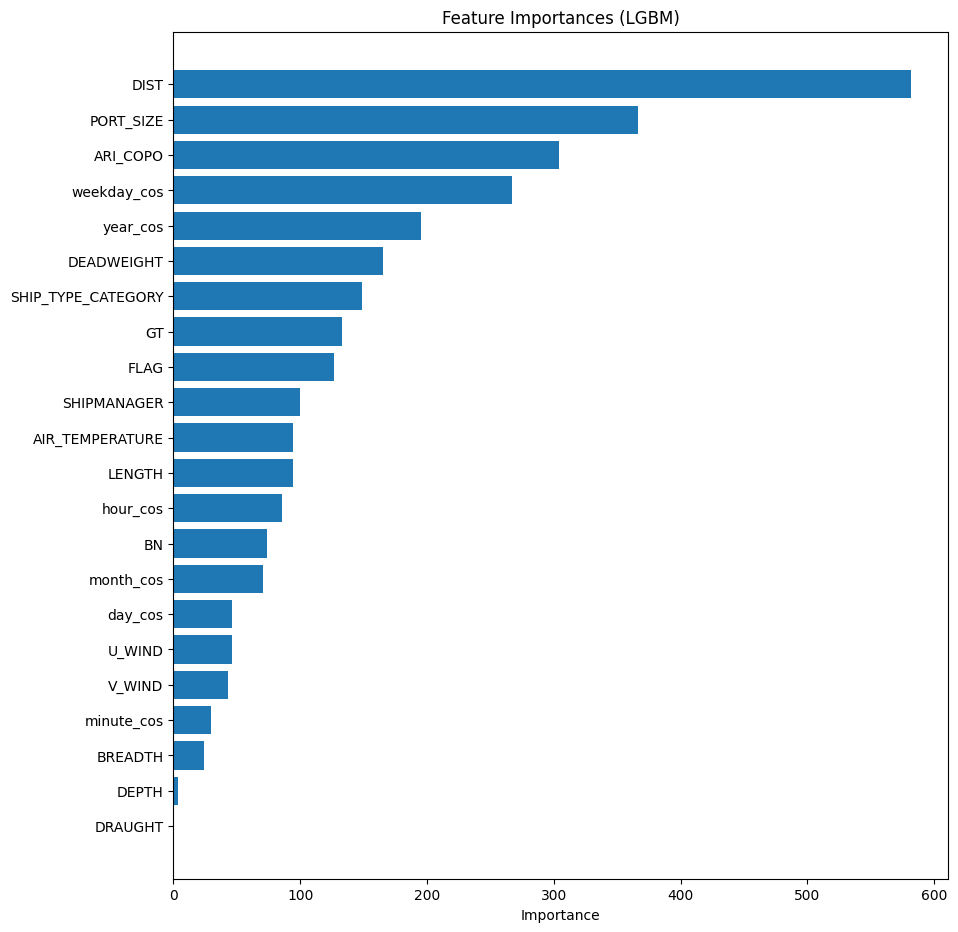

In [64]:
# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [65]:
lgbm_feature_importances

array([149, 582,  24, 165,   4,   0, 133,  94, 100, 127,  46,  43,  94,
        74, 366, 304,  86,  71,  46, 267,  30, 195], dtype=int32)

#### LGBM 으로 변수 중요도를 뽑고 각 변수들을 PCA로 압축

In [66]:
import pandas as pd

# 가상의 특성 중요도 데이터프레임 생성
feature_importance = pd.DataFrame({
    'name_list': ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'PORT_SIZE', 'ARI_COPO', 'hour_cos',
       'month_cos', 'day_cos', 'weekday_cos', 'minute_cos', 'year_cos'],
    'Importance': [165, 565,  25, 186,   5,   0, 126,  89, 110, 124,  36,  53, 114,
        72, 351, 313,  53,  60,  47, 257,  44, 205]
})

# 원하는 그룹 수 설정
num_groups = 4

# 중요도 값에 따라 특성 정렬
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# 그룹별로 특성을 나누기 위한 그룹 크기 계산
group_size = len(feature_importance) // num_groups

# 그룹별로 특성 나누기
feature_groups = []
for i in range(num_groups):
    start_idx = i * group_size
    end_idx = start_idx + group_size
    group = feature_importance.iloc[start_idx:end_idx]['name_list'].tolist()  # 'name_list'로 수정
    feature_groups.append(group)

# 원하는 그룹을 정의
# group_definitions = [['DIST', 'PORT_SIZE', 'ARI_COPO'], ['weekday_cos', 'year_cos']]
# feature_groups = []
# for group_definition in group_definitions:
#     group = feature_importance[feature_importance['name_list'].isin(group_definition)]['name_list'].tolist()
#     feature_groups.append(group)

# 결과 출력
for i, group in enumerate(feature_groups):
    print(f'Group {i + 1}: {group}')


Group 1: ['DIST', 'PORT_SIZE', 'ARI_COPO', 'weekday_cos', 'year_cos']
Group 2: ['DEADWEIGHT', 'SHIP_TYPE_CATEGORY', 'GT', 'FLAG', 'AIR_TEMPERATURE']
Group 3: ['SHIPMANAGER', 'LENGTH', 'BN', 'month_cos', 'hour_cos']
Group 4: ['V_WIND', 'day_cos', 'minute_cos', 'U_WIND', 'BREADTH']


In [67]:
feature_groups

[['DIST', 'PORT_SIZE', 'ARI_COPO', 'weekday_cos', 'year_cos'],
 ['DEADWEIGHT', 'SHIP_TYPE_CATEGORY', 'GT', 'FLAG', 'AIR_TEMPERATURE'],
 ['SHIPMANAGER', 'LENGTH', 'BN', 'month_cos', 'hour_cos'],
 ['V_WIND', 'day_cos', 'minute_cos', 'U_WIND', 'BREADTH']]

### PCA를 이용해 그룹별로 변수를 합친 뒤 변수 3개 생성

In [68]:
from sklearn.decomposition import PCA
import pandas as pd

# groups = [feature_groups[0], feature_groups[1], feature_groups[2], feature_groups[3]]
# featuregroups = [['DIST', 'PORT_SIZE'],['PORT_SIZE', 'ARI_COPO'],['weekday_cos', 'year_cos']]
groups = [feature_groups[0]]
# groups = [feature_groups[0],feature_groups[1]]

pca_data1 = []
pca_test1 = []
pca_columns = ['PCA_Group0','PCA_Group1']
for i,group in enumerate(groups):
    # 데이터 선택
    selected_data_X = X_train[group]

    # PCA
    pca = PCA(n_components=1)
    selected_data_X_pca = pca.fit_transform(selected_data_X)

    # PCA 적용 후 데이터를 데이터프레임에 추가
    pca_data1.append(pd.DataFrame(selected_data_X_pca, columns=[pca_columns[i]]))

    selected_test_X = X_test[group]

    # PCA
    pca = PCA(n_components=1)
    selected_test_X_pca = pca.fit_transform(selected_test_X)

    # PCA 적용 후 데이터를 데이터프레임에 추가
    pca_test1.append(pd.DataFrame(selected_test_X_pca, columns=[pca_columns[i]]))

# 각 그룹의 PCA 결과 데이터를 수평으로 연결하여 하나의 변수로 합침
merged_data_df = pd.concat(pca_data1, axis=1)
merged_test_df = pd.concat(pca_test1, axis=1)

# Result 확인
merged_data_df

,PCA_Group0
0,40.448497
1,2.448571
2,-26.549961
3,16.449466
4,40.448729
...,...
391934,11.448838
391935,40.449556
391936,47.446390
391937,43.448256


# 5. K-Fold Model Fitting & Validation

#### 기존 변수 Drop

In [69]:
drop_index =['SHIPMANAGER', 'LENGTH', 'BN', 'month_cos', 'hour_cos',
             'V_WIND', 'day_cos', 'minute_cos', 'U_WIND', 'BREADTH',
             'DRAUGHT','DEPTH']

X_train.drop(columns = drop_index, inplace=True)
X_test.drop(columns = drop_index, inplace=True)

In [70]:
X_train

,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,GT,FLAG,AIR_TEMPERATURE,PORT_SIZE,ARI_COPO,weekday_cos,year_cos
0,2,0.914529,1.225770,1.215628,89,0.456957,1.000000,90,1.000000,0.999879
1,0,0.000000,1.235863,1.224883,74,0.456957,0.081242,52,0.623490,0.999609
2,2,0.000000,1.268793,1.245091,73,0.456957,0.616515,23,0.623490,0.999691
3,2,0.000000,1.189837,1.182087,5,0.081081,0.134672,66,-0.900969,0.999957
4,2,0.902754,1.263718,1.259595,67,0.812813,1.000000,90,0.623490,0.999957
...,...,...,...,...,...,...,...,...,...,...
391934,2,0.000000,1.189431,1.178428,20,0.456957,0.209594,61,0.623490,0.999826
391935,0,0.729845,1.164312,1.139644,124,0.877878,1.000000,90,-0.222521,0.999923
391936,0,0.898118,1.248611,1.235075,102,0.697197,0.057661,97,0.623490,0.999981
391937,2,0.792039,1.225220,1.215957,22,0.456957,0.377319,93,-0.900969,0.999691


In [71]:
X_test

,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,GT,FLAG,AIR_TEMPERATURE,PORT_SIZE,ARI_COPO,weekday_cos,year_cos
0,2,0.712494,2.539232,2.533626,83,0.873874,1.000000,90,-0.900969,0.999957
1,1,1.452396,2.224153,2.180209,9,0.169169,0.391942,37,-0.222521,0.999981
2,2,1.454978,2.331815,2.306662,95,0.107107,0.665804,29,1.000000,0.999923
3,0,1.199952,2.479018,2.429902,83,0.453453,0.067932,15,1.000000,0.999691
4,2,0.000000,2.450285,2.433990,63,0.453453,0.209594,61,-0.222521,0.999879
...,...,...,...,...,...,...,...,...,...,...
220486,0,1.416563,2.510280,2.473251,55,0.453453,0.028917,11,0.623490,0.999826
220487,0,1.018825,2.509276,2.456334,63,0.453453,0.013099,16,1.000000,0.999764
220488,3,1.359478,2.090741,1.976385,55,0.884384,0.099500,65,0.623490,0.999995
220489,1,0.000000,2.212407,2.151925,9,0.094532,0.226047,30,1.000000,0.999957


In [72]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

X_train_f = pd.concat([X_train, merged_data_df], axis=1)
X_test_f = pd.concat([X_test, merged_test_df], axis=1)

for train_idx, val_idx in kf.split(X_train_f):
    X_t, X_val = X_train_f.iloc[train_idx], X_train_f.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_f)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1593
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 11
[LightGBM] [Info] Start training from score 22.415992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1593
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 11
[LightGBM] [Info] Start training from score 22.390651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

### 모델 앙상블

In [30]:
!pip install pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 12.4

In [78]:
X_train_py = pd.concat([X_train_f, y_train], axis=1)
X_train_py.columns

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'DEADWEIGHT', 'GT', 'FLAG',
       'AIR_TEMPERATURE', 'PORT_SIZE', 'ARI_COPO', 'weekday_cos', 'year_cos',
       'PCA_Group0', 'CI_HOUR'],
      dtype='object')

In [80]:
# pycaret 설정
from pycaret.regression import *

setup_model = setup(data=X_train_py, target='CI_HOUR', train_size=0.8, use_gpu=True,
                    fold=5, fold_shuffle=True,
                    feature_selection=True, feature_selection_method='classic')

# compare_models 함수를 사용하여 여러 회귀 모델을 비교하고
# 가장 성능이 좋은 모델을 선택
best_model = compare_models(sort='MAE', n_select = 5)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,3224
1,Target,CI_HOUR
2,Target type,Regression
3,Original data shape,"(391939, 12)"
4,Transformed data shape,"(391939, 3)"
5,Transformed train set shape,"(313551, 3)"
6,Transformed test set shape,"(78388, 3)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,11.9739,398.0731,19.9514,0.5107,0.7468,2.5126,4.4120
xgboost,Extreme Gradient Boosting,11.9854,398.2423,19.9557,0.5105,0.7561,2.2347,2.8240
catboost,CatBoost Regressor,12.1212,404.1664,20.1036,0.5032,0.7555,2.6038,11.5760
gbr,Gradient Boosting Regressor,12.4769,413.0082,20.3223,0.4923,0.8236,2.6568,15.2080
knn,K Neighbors Regressor,12.8570,471.3878,21.7113,0.4205,0.7642,2.4245,5.5740
ada,AdaBoost Regressor,13.2893,452.3212,21.2677,0.4440,0.8514,3.7539,4.3460
omp,Orthogonal Matching Pursuit,13.3523,456.0660,21.3555,0.4394,0.8171,2.8496,3.2480
rf,Random Forest Regressor,13.5954,537.7111,23.1883,0.3390,0.7902,2.4410,37.5600
huber,Huber Regressor,13.7130,451.2538,21.2425,0.4453,0.9668,2.6325,3.0880
br,Bayesian Ridge,13.8863,449.7142,21.2062,0.4472,1.0476,2.6964,2.5800


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [81]:
top5 = [rank for rank in best_model]

tuned_top5 = [tune_model(i) for i in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12.4326,400.7017,20.0175,0.5086,0.9175,2.5531
1,12.4029,398.9754,19.9744,0.5100,0.9147,2.3350
2,12.3473,394.9174,19.8725,0.5114,0.9177,2.5308
3,12.4141,395.0180,19.8751,0.5093,0.9223,2.5593
4,12.5266,407.7298,20.1923,0.5055,0.9176,2.5706
Mean,12.4247,399.4685,19.9864,0.5090,0.9180,2.5098
Std,0.0584,4.7017,0.1174,0.0020,0.0024,0.0883


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12.2721,399.9145,19.9979,0.5095,0.8700,2.2433
1,12.2426,398.8758,19.9719,0.5101,0.8644,2.0874
2,12.1807,393.8424,19.8455,0.5128,0.8685,2.2336
3,12.2596,394.5583,19.8635,0.5099,0.8733,2.2841
4,12.3731,406.8062,20.1694,0.5066,0.8703,2.2420
Mean,12.2656,398.7994,19.9696,0.5098,0.8693,2.2181
Std,0.0622,4.6458,0.1161,0.0020,0.0029,0.0676


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 250840, number of used features: 11
[LightGBM] [Info] Start training from score 22.384381
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 250841, number of used features: 11
[LightGBM] [Info] Start training from score 22.407025
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12.0903,405.2662,20.1312,0.5030,0.7519,2.6206
1,12.0854,403.2674,20.0815,0.5047,0.7490,2.4067
2,12.0129,399.2819,19.9820,0.5060,0.7513,2.6152
3,12.0997,400.2635,20.0066,0.5028,0.7585,2.6186
4,12.2239,412.2109,20.3030,0.5000,0.7543,2.7136
Mean,12.1024,404.0580,20.1009,0.5033,0.7530,2.5949
Std,0.0682,4.5992,0.1142,0.0020,0.0032,0.1011


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 250840, number of used features: 11
[LightGBM] [Info] Start training from score 22.384381
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 250841, number of used features: 11
[LightGBM] [Info] Start training from score 22.407025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033754 seconds.
You can se

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12.0105,400.5655,20.0141,0.5087,0.7470,2.5702
1,11.9549,397.9096,19.9477,0.5113,0.7402,2.3067
2,11.8997,394.0442,19.8505,0.5125,0.7448,2.4949
3,11.9984,394.6116,19.8648,0.5098,0.7528,2.5426
4,12.1016,407.7183,20.1920,0.5055,0.7457,2.3845
Mean,11.9930,398.9699,19.9738,0.5096,0.7461,2.4598
Std,0.0668,4.9691,0.1241,0.0024,0.0040,0.0994


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12.0568,408.9163,20.2217,0.4985,0.7444,2.4883
1,12.0143,406.5851,20.1640,0.5007,0.7371,2.3336
2,11.9614,401.3435,20.0336,0.5035,0.7411,2.4667
3,12.0709,403.8996,20.0973,0.4983,0.7503,2.5881
4,12.1661,414.4908,20.3590,0.4973,0.7436,2.3869
Mean,12.0539,407.0471,20.1751,0.4996,0.7433,2.4527
Std,0.0678,4.5068,0.1116,0.0022,0.0043,0.0875


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [82]:
blended = blend_models(estimator_list = tuned_top5,
                       fold = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11.8236,388.4624,19.7094,0.5165,0.7402,2.4794
1,12.1074,409.3657,20.2328,0.5051,0.7492,2.5088
2,11.8843,396.5486,19.9135,0.5136,0.7385,2.2927
3,11.9683,396.8677,19.9215,0.5119,0.7397,2.3074
4,11.8759,392.0427,19.8001,0.5102,0.7450,2.4603
5,11.8555,393.1327,19.8276,0.5183,0.7398,2.4560
6,11.9240,391.9073,19.7966,0.5097,0.7477,2.5504
7,11.9646,394.4612,19.8610,0.5134,0.7500,2.4861
8,12.0443,403.7040,20.0924,0.5093,0.7448,2.4886


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [83]:
# from pycaret.classification import load_model
# from pycaret.classification import predict_model
# blended = load_model('/content/drive/MyDrive/HD/pycaret_temp_model') #확장자 pkl 빼야함.

In [84]:
prediction = predict_model(blended, data=pd.DataFrame(X_test_f))

In [85]:
prediction

,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,GT,FLAG,AIR_TEMPERATURE,PORT_SIZE,ARI_COPO,weekday_cos,year_cos,PCA_Group0,prediction_label
0,2,0.712494,2.539232,2.533626,83,0.873874,1.000000,90,-0.900969,0.999957,40.426472,23.867588
1,1,1.452396,2.224153,2.180209,9,0.169169,0.391942,37,-0.222521,0.999981,-12.577611,44.888163
2,2,1.454978,2.331815,2.306662,95,0.107107,0.665804,29,1.000000,0.999923,-20.577492,38.029783
3,0,1.199952,2.479018,2.429903,83,0.453453,0.067932,15,1.000000,0.999691,-34.577885,39.482938
4,2,0.000000,2.450285,2.433990,63,0.453453,0.209594,61,-0.222521,0.999879,11.427111,-0.051871
...,...,...,...,...,...,...,...,...,...,...,...,...
220486,0,1.416563,2.510280,2.473251,55,0.453453,0.028917,11,0.623490,0.999826,-38.578552,55.081298
220487,0,1.018825,2.509276,2.456334,63,0.453453,0.013099,16,1.000000,0.999764,-33.577354,41.772505
220488,3,1.359478,2.090741,1.976385,55,0.884384,0.099500,65,0.623490,0.999995,15.421286,53.685868
220489,1,0.000000,2.212407,2.151925,9,0.094532,0.226047,30,1.000000,0.999957,-19.573166,-0.043058


In [90]:
# 제출용 sample 파일불러오기
submission = pd.read_csv('/content/drive/MyDrive/HD/Data/sample_submission.csv')
submission.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,23.867588
1,TEST_000001,44.888163
2,TEST_000002,38.029783
3,TEST_000003,39.482938
4,TEST_000004,-0.051871


In [87]:
# Submission 파일에 예측값 할당
submission['CI_HOUR'] = prediction['prediction_label']

In [88]:
# CSV 파일로 저장
submission.to_csv("/content/drive/MyDrive/HD/Data/sample_submission.csv", index=False)

In [89]:
from google.colab import files
files.download("/content/drive/MyDrive/HD/Data/sample_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
save_model(blended, "/content/drive/MyDrive/HD/pycaret_temp_model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['SHIP_TYPE_CATEGORY', 'DIST',
                                              'DEADWEIGHT', 'GT', 'FLAG',
                                              'AIR_TEMPERATURE', 'PORT_SIZE',
                                              'ARI_COPO', 'weekday_cos',
                                              'year_cos', 'PCA_Group0'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most...
                                               <catboost.core.CatBoostRegressor object at 0x7dd09473efe0>),
                                              ('Gradient Boosting Regressor',
                                               GradientBoostingRegressor(learning_rate=0.05,
                             

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

# 각 회귀 모델 생성
gb_model = GradientBoostingRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
catboost_model = CatBoostRegressor(random_state=42, verbose=0)
rf_model = RandomForestRegressor(random_state=42)
svr_model = SVR()

# VotingRegressor 생성
voting_regressor = VotingRegressor(estimators=[
    ('gb', gb_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('svr', svr_model)
], weights=[1, 2, 1, 2, 1, 1])

# VotingRegressor 학습
voting_regressor.fit(X_train_f, y_train)

# VotingRegressor로 예측
voting_pred = voting_regressor.predict(X_val)

# MAE 계산
voting_mae = mean_absolute_error(y_val, voting_pred)
print(f"VotingRegressor MAE: {voting_mae}")

In [73]:
# 제출용 sample 파일불러오기
submission = pd.read_csv('/content/drive/MyDrive/HD/Data/sample_submission.csv')
submission.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,26
1,TEST_000001,51
2,TEST_000002,39
3,TEST_000003,48
4,TEST_000004,0


In [30]:
# Submission 파일에 예측값 할당
submission['CI_HOUR'] = voting_pred

# CSV 파일로 저장
submission.to_csv("./HD/Data/sample_submission.csv", index=False)

NameError: ignored

In [31]:
from google.colab import files
files.download("./HD/Data/sample_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

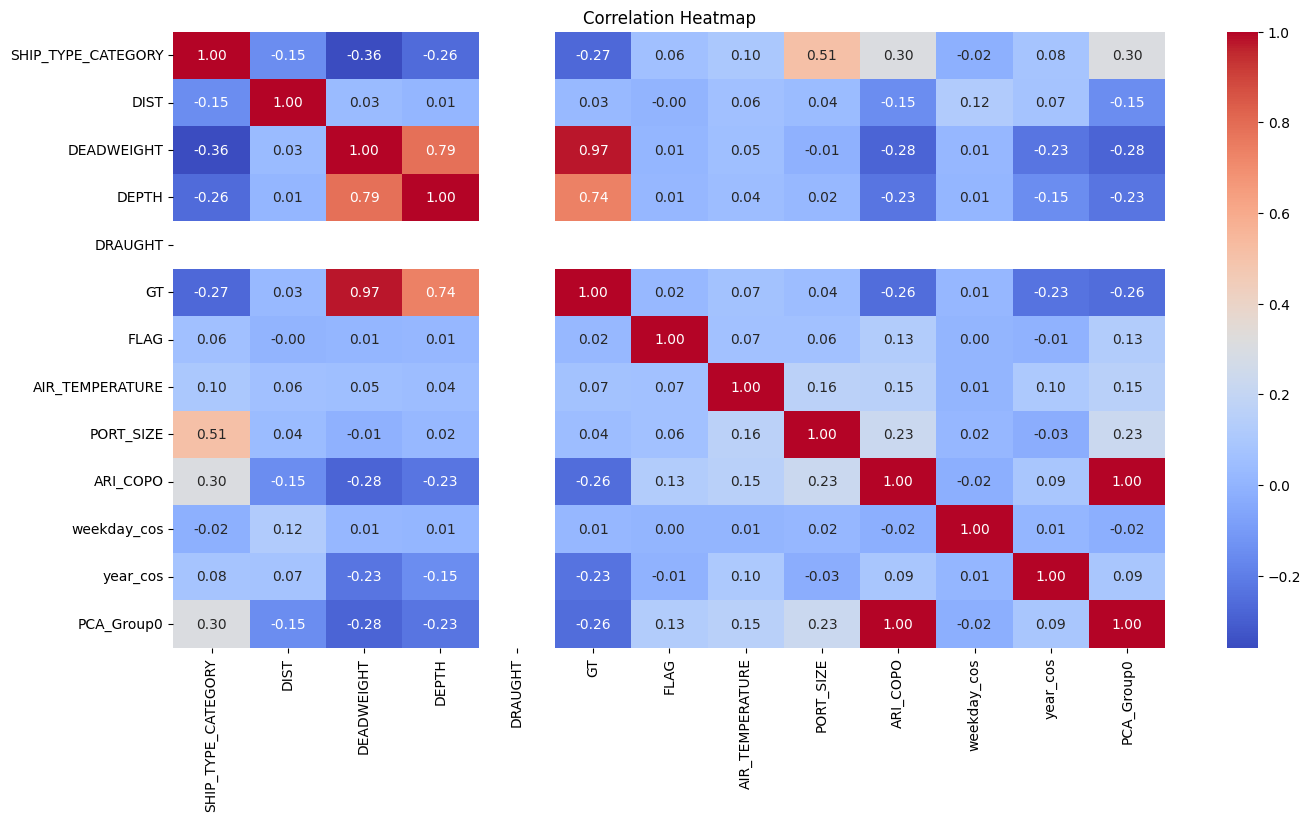

In [ ]:
# # 시각화를 통한 데이터 탐색
# plt.figure(figsize=(16, 8))
# sns.heatmap(X_train_f.corr(), annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap')
# plt.show()

In [ ]:
# X_train_f.columns

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT',
       'FLAG', 'AIR_TEMPERATURE', 'PORT_SIZE', 'ARI_COPO', 'weekday_cos',
       'year_cos', 'PCA_Group0'],
      dtype='object')

### 데이터 상관계수가 0.5이상인 것 끼리 합치고 합친 것들은 Drop한다

In [ ]:
# # 원하는 그룹을 정의
# Corr_group = [['SHIP_TYPE_CATEGORY','PORT_SIZE'], ['DEADWEIGHT', 'DEPTH', 'GT'],['ARI_COPO','PCA_Group0']]
# Corr_feature_groups = []

# for group_definition in Corr_group:
#     group = feature_importance[feature_importance['name_list'].isin(group_definition)]['name_list'].tolist()
#     Corr_feature_groups.append(group)

# # 결과 출력
# for i, group in enumerate(Corr_feature_groups):
#     print(f'Group {i + 1}: {group}')

Group 1: ['PORT_SIZE', 'SHIP_TYPE_CATEGORY']
Group 2: ['DEADWEIGHT', 'GT', 'DEPTH']
Group 3: ['ARI_COPO']


In [ ]:
# from sklearn.decomposition import PCA
# import pandas as pd

# pca_data1 = []  # PCA 결과를 저장할 리스트
# pca_test1 = []  # 테스트 데이터의 PCA 결과를 저장할 리스트

# corr_groups = [Corr_feature_groups[0],Corr_feature_groups[1],Corr_feature_groups[2]]
# corr_columns = ['SHIP_PORT','DEAD_DEPTH_GT', 'ARI_0']

# for i,group in enumerate(corr_groups):
#     # 데이터 선택
#     selected_data_X = X_train[group]

#     # PCA
#     pca = PCA(n_components=1)
#     selected_data_X_pca = pca.fit_transform(selected_data_X)

#     # PCA 적용 후 데이터를 데이터프레임에 추가
#     pca_data1.append(pd.DataFrame(selected_data_X_pca, columns=[corr_columns[i]]))

#     selected_test_X = X_test[group]

#     # PCA
#     pca = PCA(n_components=1)
#     selected_test_X_pca = pca.fit_transform(selected_test_X)

#     # PCA 적용 후 데이터를 데이터프레임에 추가
#     pca_test1.append(pd.DataFrame(selected_test_X_pca, columns=[corr_columns[i]]))

# # 결과를 데이터프레임으로 변환
# pca_data1_df = pd.concat(pca_data1, axis=1)
# pca_test1_df = pd.concat(pca_test1, axis=1)

# # 결과 출력
# print(pca_data1_df)
# print(pca_test1_df)


        SHIP_PORT  DEAD_DEPTH_GT      ARI_0
0        0.990708       0.213055  40.448496
1       -1.136675       0.210383   2.448496
2        0.925310      -0.450718 -26.551504
3        0.843140       0.222651  16.448496
4        0.990708      -0.125186  40.448496
...           ...            ...        ...
391934   0.855917       0.223223  11.448496
391935  -0.979996       0.232101  40.448496
391936  -1.140697      -0.119678  47.448496
391937   0.884520       0.213082  43.448496
391938   0.884520      -0.119621  43.448496

[391939 rows x 3 columns]
        SHIP_PORT  DEAD_DEPTH_GT      ARI_0
0        0.990810      -0.465731  40.424475
1       -0.098337       0.350459 -12.575525
2        0.933741       0.246758 -20.575525
3       -1.138978      -0.132613 -34.575525
4        0.855836      -0.122119  11.424475
...           ...            ...        ...
220486  -1.145641      -0.425869 -38.575525
220487  -1.148342      -0.157622 -33.575525
220488   1.822348       0.760497  15.424475
22048

In [ ]:
# drop_index =['SHIP_TYPE_CATEGORY','PORT_SIZE','DEADWEIGHT', 'DEPTH', 'GT','ARI_COPO','PCA_Group0','DRAUGHT']

# X_train_f.drop(columns = drop_index, inplace=True)
# X_test_f.drop(columns = drop_index, inplace=True)

In [ ]:
# X_train_f.columns

Index(['DIST', 'FLAG', 'AIR_TEMPERATURE', 'weekday_cos', 'year_cos'], dtype='object')

In [ ]:
# X_test_f.columns

Index(['DIST', 'FLAG', 'AIR_TEMPERATURE', 'weekday_cos', 'year_cos'], dtype='object')

In [ ]:
# lgbm = lgb.LGBMRegressor()

# # 5-Fold 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
# ensemble_predictions = []
# scores = []

# X_train_2 = pd.concat([X_train_f, pca_data1_df], axis=1)
# X_test_2 = pd.concat([X_test_f, pca_test1_df], axis=1)

# for train_idx, val_idx in kf.split(X_train_2):
#     X_t, X_val = X_train_2.iloc[train_idx], X_train_2.iloc[val_idx]
#     y_t, y_val = y_train[train_idx], y_train[val_idx]

#     # 두 모델 모두 학습
#     lgbm.fit(X_t, y_t)

#     # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
#     val_pred = lgbm.predict(X_val)

#     # Validation set에 대한 대회 평가 산식 계산 후 저장
#     scores.append(mean_absolute_error(y_val, val_pred))

#     # test 데이터셋에 대한 예측 수행 후 저장
#     lgbm_pred = lgbm.predict(X_test_2)
#     lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

#     ensemble_predictions.append(lgbm_pred)

# # K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
# final_predictions = np.mean(ensemble_predictions, axis=0)

# # 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
# print("Validation : MAE scores for each fold:", scores)
# print("Validation : MAE:", np.mean(scores))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1190
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 8
[LightGBM] [Info] Start training from score 22.415992
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 8
[LightGBM] [Info] Start training from score 22.390651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

### Randomforest 이용

In [ ]:
ada = RandomForestRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in kf.split(X_train):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    ada.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = ada.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    ada_pred = ada.predict(X_test)
    ada_pred = np.where(ada_pred < 0, 0, ada_pred)

    ensemble_predictions.append(ada_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

KeyboardInterrupt: ignored

# 6. Submission

In [58]:
# 제출용 sample 파일불러오기
submission = pd.read_csv('/content/drive/MyDrive/HD/Data/sample_submission.csv')
submission.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,14.620673
1,TEST_000001,37.835778
2,TEST_000002,31.530522
3,TEST_000003,52.283353
4,TEST_000004,0.000000


In [74]:
# predictions = final_predictions.predict(test)
# predictions = np.where(predictions < 0, 0, predictions)
# submission["CI_HOUR"]=predictions
# submission.head()

submission['CI_HOUR'] =  final_predictions

In [75]:
submission.to_csv("./HD/Data/sample_submission.csv",index = False)

In [76]:
from google.colab import files
files.download("./HD/Data/sample_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>